In [1]:
import collections
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Embedding,Dropout,Dense,Activation,concatenate,Input)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1=pd.read_csv('Desktop/压缩包/data/data.csv',index_col=0)
df1.head()

,留言编号,留言用户,留言主题,留言时间,一级标签,留言详情_cut,留言详情_word_cut,留言详情_char_cut
0,24,A00074011,A市西湖建筑集团占道施工有安全隐患,2020/1/6 12:09:38,城乡建设,区大道西行便道未管所路口至加油站路段人行道包括路灯杆被圈西湖建筑集团燕子山安置房项目施工围墙...,区 大道 西行 便道 未管 所 路口 至 加油站 路段 人行道 包括 路灯 杆 被 圈 西湖...,区 大 道 西 行 便 道 未 管 所 路 口 至 加 油 站 路 段 人 行 道 包 括 ...
1,37,U0008473,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/4 11:17:46,城乡建设,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水、电等设施后烂尾多年用护栏围着不但占用人行...,位于 书院 路 主干道 的 在水一方 大厦 一楼 至 四楼 人为 拆除 水 、 电等 设施 ...,位 于 书 院 路 主 干 道 的 在 水 一 方 大 厦 一 楼 至 四 楼 人 为 拆 ...
2,83,A00063999,投诉A市A1区苑物业违规收停车费,2019/12/30 17:06:14,城乡建设,尊敬的领导区苑小区位于区火炬路小区物业市程明物业管理有限公司未经小区业主同意利用业主的公摊公...,尊敬 的 领导 区苑 小区 位于 区 火炬 路 小区 物业 市程明 物业管理 有限公司 未经...,尊 敬 的 领 导 区 苑 小 区 位 于 区 火 炬 路 小 区 物 业 市 程 明 物 ...
3,303,U0007137,A1区蔡锷南路A2区华庭楼顶水箱长年不洗,2019/12/6 14:40:14,城乡建设,区区华庭小区高层为二次供水楼顶水箱长年不洗现在自来水龙头的水严重霉味大家都知道水是我们日常生...,区区 华庭 小区 高层 为 二次 供水 楼顶 水箱 长年 不洗 现在 自来水 龙头 的 水 ...,区 区 华 庭 小 区 高 层 为 二 次 供 水 楼 顶 水 箱 长 年 不 洗 现 在 ...
4,319,U0007137,A1区A2区华庭自来水好大一股霉味,2019/12/5 11:17:22,城乡建设,区区华庭小区高层为二次供水楼顶水箱长年不洗现在自来水龙头的水严重霉味大家都知道水是我们日常生...,区区 华庭 小区 高层 为 二次 供水 楼顶 水箱 长年 不洗 现在 自来水 龙头 的 水 ...,区 区 华 庭 小 区 高 层 为 二 次 供 水 楼 顶 水 箱 长 年 不 洗 现 在 ...


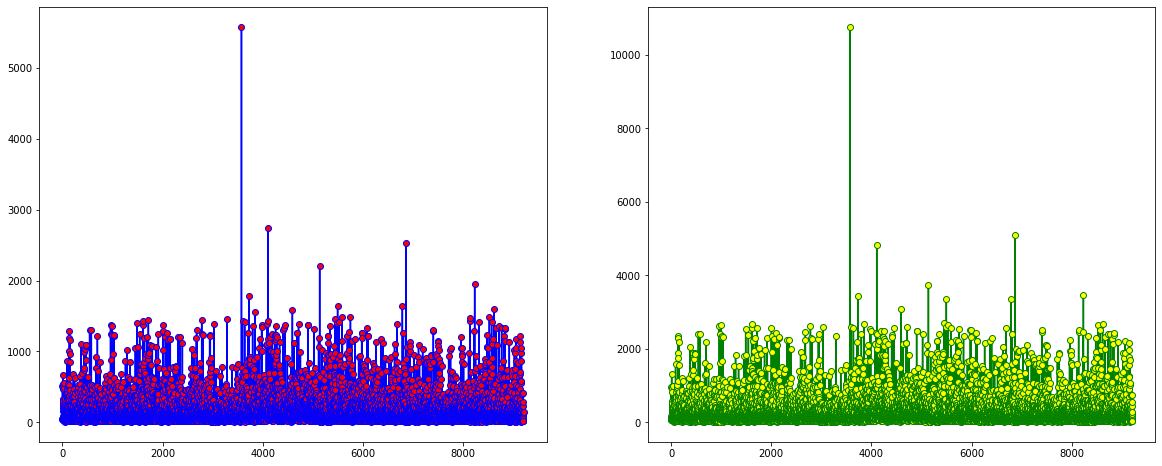

In [3]:
df1['word_length'] = df1["留言详情_word_cut"].map(lambda x: len(x.split(" ")))
df1['char_length'] = df1["留言详情_char_cut"].map(lambda x: len(x.split(" ")))
"'可视化查看长度'"
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(df1['word_length'].tolist(),c='b',marker='o',markerfacecolor='red')
plt.subplot(122)
plt.plot(df1['char_length'].tolist(),c='green',marker='o',markerfacecolor='yellow')

## 给数据编码

In [4]:
"'单词映射到id'"
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=90000, lower=False,filters="")
tokenizer.fit_on_texts(df1['留言详情_word_cut'].tolist())
word_index = tokenizer.word_index
len(word_index.keys())

81164

In [5]:
"'将评论转换成单词索引序列'"
sentences_ = tokenizer.texts_to_sequences(df1['留言详情_word_cut'].values)

In [6]:
np.percentile(df1['留言详情_word_cut'].map(lambda x:len(x)),95)

1792.7499999999964

In [7]:
X= tf.keras.preprocessing.sequence.pad_sequences(sentences_,maxlen=1750,padding='pre',truncating='pre',value=0.0)

## 标签处理

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
lb = LabelEncoder().fit(df1['一级标签'].values)
lb.classes_

array(['交通运输', '劳动和社会保障', '卫生计生', '商贸旅游', '城乡建设', '教育文体', '环境保护'],
      dtype=object)

In [9]:
label = lb.transform(df1['一级标签'].values)
label = to_categorical(label)

In [10]:
from sklearn.model_selection import train_test_split
y=label
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.3,random_state=42)

## 构建词向量矩阵

In [11]:
import gensim
from gensim.models import Word2Vec
model_= Word2Vec.load('Desktop/压缩包/deep_learning/word2vec_200.model')

In [13]:
count = 0

embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = model_.wv[word] if word in model_ else None
    if embedding_vector is not None:
        count += 1
        embedding_matrix[i] = embedding_vector
    else:
        unknown_vector = np.random.random(200) * 0.5
        unknown_vector = unknown_vector - unknown_vector.mean()
        embedding_matrix[i] = unknown_vector

In [14]:
embedding_matrix.shape

(81165, 200)

## 模型预测

In [16]:
"'TextCNN文本分类'"
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

num_features=embedding_matrix.shape[0]#词汇表大小
sequence_length=1750#输入序列的长度
embedding_dimension=embedding_matrix.shape[1]#词向量维度
filter_sizes=[3,4,5]#3*100
def convolution():
    inputt=layers.Input(shape=(sequence_length,embedding_dimension,1))
    cnns=[]
    for size in filter_sizes:
        conv=layers.Conv2D(filters=6,kernel_size=(size,embedding_dimension),strides=1,padding='valid',activation='relu')(inputt)
        pool=layers.MaxPool2D(pool_size=(sequence_length-size+1,1),padding='valid')(conv)
        cnns.append(pool)
    outputt=layers.concatenate(cnns)#1*(6*3)
    model=keras.Model(inputs=inputt,outputs=outputt)
    return model

def cnn_mulfilter():
    model=keras.Sequential([
        layers.Embedding(input_dim=num_features,output_dim=embedding_dimension,input_length=sequence_length)
        ,layers.Reshape((sequence_length,embedding_dimension,1))
        ,convolution()
        ,layers.Flatten()
        ,layers.Dense(60,activation='relu')
        ,layers.Dropout(0.2)
        ,layers.Dense(7,activation='softmax')])
    model.compile(optimizer=keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model=cnn_mulfilter()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1750, 200)         16233000  
_________________________________________________________________
reshape_1 (Reshape)          (None, 1750, 200, 1)      0         
_________________________________________________________________
model (Model)                (None, 1, 1, 18)          14418     
_________________________________________________________________
flatten (Flatten)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 60)                1140      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 4

In [18]:
history=model.fit(X_train,y_train,epochs=5)

Train on 6447 samples
Epoch 1/5
6447/6447 [==============================] - 117s 18ms/sample - loss: 0.5380 - accuracy: 0.8415
Epoch 2/5
6447/6447 [==============================] - 120s 19ms/sample - loss: 0.1611 - accuracy: 0.9618
Epoch 3/5
6447/6447 [==============================] - 117s 18ms/sample - loss: 0.0503 - accuracy: 0.9915
Epoch 4/5
6447/6447 [==============================] - 114s 18ms/sample - loss: 0.0264 - accuracy: 0.9966
Epoch 5/5
6447/6447 [==============================] - 112s 17ms/sample - loss: 0.0180 - accuracy: 0.9980


In [20]:
valid_prob = model.predict(X_val)
valid_pred = np.argmax(valid_prob,axis=1)
valid_pred = lb.inverse_transform(valid_pred)

val_true = np.argmax(y_val,axis=1)
val_true = lb.inverse_transform(val_true)

from sklearn.metrics import f1_score
print ("valid's f1: %s" % f1_score(val_true,valid_pred,average='macro'))

valid's f1: 0.8371576053979256
